# Single-Station HVSR Analysis with Real Data

This notebook demonstrates HVSR (Horizontal-to-Vertical Spectral Ratio) analysis using real seismic data from a single station.


## 1. Setup and Imports


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

from obspy import read, Stream
from obspy.core import UTCDateTime
import tqdm
from scipy.signal import welch

from hvsr_lite.core import compute_hvsr, HVSRResult
from hvsr_lite.utils import stream_to_dict


## 2. Load Real MiniSEED Data

In [2]:
data_dir = Path('/home/syuan/BHP/MSEED_RESP_REMOVED_Prefil')

station_name =  '453000225' 
date_str = '2022.07.21.00.00.00.000'

components = {'E': 'east', 'N': 'north', 'Z': 'vertical'}
streams = {}

for comp_code, comp_name in components.items():
    pattern = f"{station_name}..0.*.{date_str}.{comp_code}_RESPREMOVED.miniseed"
    matches = sorted(data_dir.glob(pattern))

    if not matches:
        print(f"File not found (pattern): {pattern}")
        continue

    filepath = matches[0]
    st = read(str(filepath))
    streams[comp_name] = st

st_all = Stream()
for comp_name in ['north', 'east', 'vertical']:
    if comp_name in streams:
        st_all += streams[comp_name]

print(f"Loaded {len(st_all)} components")

Loaded 3 components


## 3. Data Preprocessing


Preprocessing steps:
1.Removing mean...
2.Removing linear trend...
3.Applying taper...
4.Applying bandpass filter (0.2-10 Hz)...


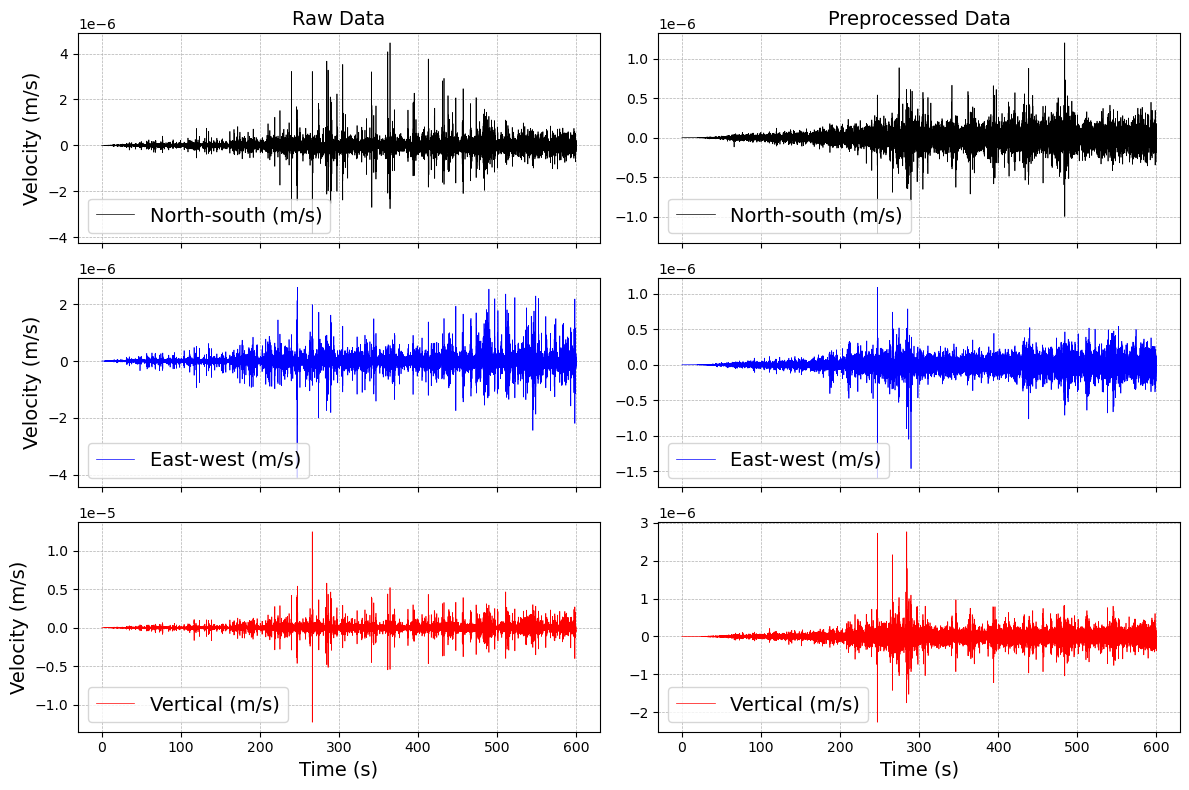

In [3]:
st_processed = st_all.copy()

print("Preprocessing steps:")
print("1.Removing mean...")
st_processed.detrend(type='demean')

print("2.Removing linear trend...")
st_processed.detrend(type='linear')

print("3.Applying taper...")
st_processed.taper(max_percentage=0.001)

print("4.Applying bandpass filter (0.2-10 Hz)...")
st_processed.filter('bandpass', freqmin=0.2, freqmax=10.0, corners=4, zerophase=True)


fig, axes = plt.subplots(3, 2, figsize=(12, 8), sharex='col')
legend_names = ['North-south (m/s)', 'East-west (m/s)', 'Vertical (m/s)']
colors = ['k', 'b', 'r']

duration = 60*10  # 10 minutes in seconds
sampling_rate = st_all[0].stats.sampling_rate
n_samples = int(duration * sampling_rate)

for i, (tr_raw, tr_proc, color) in enumerate(zip(st_all, st_processed, colors)):
    time = np.arange(n_samples) / sampling_rate
    
    # Raw data
    axes[i, 0].plot(time, tr_raw.data[:n_samples], color=color, linewidth=0.5,label=legend_names[i])
    axes[i, 0].set_ylabel('Velocity (m/s)', fontsize=14)
    axes[i, 0].grid(True,linestyle='--',linewidth=0.5)
    axes[i, 0].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    axes[i, 0].legend(loc='lower left', fontsize=14)
    if i == 0:
        axes[i, 0].set_title('Raw Data', fontsize=14)
    
    # Processed data
    axes[i, 1].plot(time, tr_proc.data[:n_samples], color=color, linewidth=0.5,label=legend_names[i])
    axes[i, 1].grid(True,linestyle='--',linewidth=0.5)
    axes[i, 1].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    axes[i, 1].legend(loc='lower left', fontsize=14)
    if i == 0:
        axes[i, 1].set_title('Preprocessed Data', fontsize=14)

axes[-1, 0].set_xlabel('Time (s)', fontsize=14)
axes[-1, 1].set_xlabel('Time (s)', fontsize=14)
plt.tight_layout()
plt.show()

## 4. Extract Time Window for HVSR

In [4]:
start_time = st_processed[0].stats.starttime  
end_time = start_time + 20 * 3600  # 2 hours duration

print(f"Extracting time window for HVSR:")
print(f" Start: {start_time}")
print(f" End: {end_time}")
print(f" Duration: {(end_time - start_time)/60:.0f} minutes")
print(f" This will allow for 300s windows with good overlap")

# Trim to selected window
st_hvsr = st_processed.copy()
st_hvsr.trim(starttime=start_time, endtime=end_time)

print(f"Window extracted: {st_hvsr[0].stats.npts} samples per component")

hvsr_data = stream_to_dict(st_hvsr)
print(f"Converted to dictionary format")
print(f" Keys: {list(hvsr_data.keys())}")
print(f" Sampling rate: {hvsr_data['sampling_rate']} Hz")

Extracting time window for HVSR:
  Start: 2022-07-21T00:00:00.000000Z
  End: 2022-07-21T20:00:00.000000Z
  Duration: 1200 minutes
  This will allow for 300s windows with good overlap

Window extracted: 18000001 samples per component

Converted to dictionary format
  Keys: ['sampling_rate', 'north', 'east', 'vertical']
  Sampling rate: 250.0 Hz


## 5. Compute HVSR

In [5]:
# Set parameters
overlap = 0.1
window_length = 60.0  # seconds
ko_bandwidth = 40.0 
fmin = 0.2
fmax = 10.0

print("HVSR Processing Parameters:")
print(f" Window length: {window_length} seconds")
print(f" Overlap: {overlap*100:.0f}%")

horizontal_components = np.column_stack([hvsr_data['north'], hvsr_data['east']])

print(f"Computing HVSR with {window_length}s windows...")

result = compute_hvsr(
    horizontal_data=horizontal_components,
    vertical_data=hvsr_data['vertical'],
    sampling_rate=sampling_rate,
    window_length=window_length,
    overlap=overlap,
    horizontal_combine="geometric_mean",
    ko_bandwidth=ko_bandwidth,
    # Stacking
    stacking="logmean",
    # QC
    sta_lta_ratio_threshold=4.,
    max_amplitude_threshold=None,
    # Frequency limits
    min_frequency=0.2,
    max_frequency=10.0,
)

print(f"HVSR computation complete!")


HVSR Processing Parameters:
 Window length: 60.0 seconds
 Overlap: 10%
Computing HVSR with 60.0s windows...


Processing windows:   0%|          | 0/1333 [00:00<?, ?win/s]

HVSR computation complete!


## 6. Visualize HVSR Results

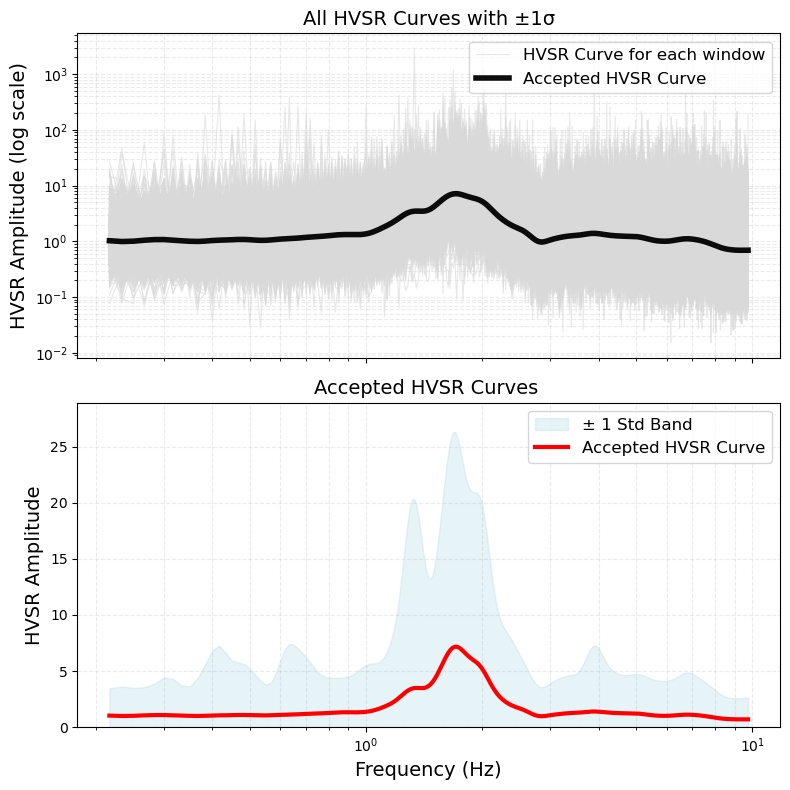

In [6]:

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

freq = result.frequencies
hvsr_main = result.hvsr_values
hvsr_mean = getattr(result, 'hvsr_mean', None)
hvsr_std  = getattr(result, 'hvsr_std', None)
window_hvsr = getattr(result, 'window_hvsr', None)

if window_hvsr is not None:
    for i in range(window_hvsr.shape[0]):
        if i == 0:
            ax1.plot(freq, window_hvsr[i], color='0.85', linewidth=0.8, alpha=0.6,label='HVSR Curve for each window')
        else:
            ax1.plot(freq, window_hvsr[i], color='0.85', linewidth=0.8, alpha=0.6)

# Accepted/smoothed curve
ax1.plot(freq, hvsr_main, color='k', linewidth=4, alpha=0.95, label='Accepted HVSR Curve')

try:
    ax1.plot(peak_freq, peak_amp, marker='o', markersize=6, color='white', mec='black', linestyle='None', label=fr'$f_0$:{peak_freq:.3f} Hz')
except Exception:
    pass

ax1.set_xscale('log')
ax1.set_yscale('log')  # Use log scale for y-axis to better show all curves
ax1.set_ylabel('HVSR Amplitude (log scale)', fontsize=14)
ax1.set_title('All HVSR Curves with ±1σ', fontsize=14)
ax1.grid(True, which='both', linestyle='--', alpha=0.25)
ax1.legend(loc='upper right', fontsize=12)

if hvsr_mean is not None and hvsr_std is not None:
    mean_max = max(hvsr_mean.max(), hvsr_main.max())
    std_max = (hvsr_mean + hvsr_std).max()
    y_max = max(mean_max, std_max) * 1.1
    
    upper = hvsr_mean + hvsr_std
    lower = np.maximum(hvsr_mean - hvsr_std, 0)
    
    ax2.fill_between(freq, lower, upper, color='lightblue', alpha=0.3, label='± 1 Std Band')
    ax2.plot(freq, hvsr_main, 'r-', linewidth=3, label='Accepted HVSR Curve')
    
    try:
        ax2.plot(peak_freq, peak_amp, marker='o', markersize=8, color='white', mec='red', linestyle='None', label=fr'$f_0$:{peak_freq:.3f} Hz')
    except Exception:
        pass
    
    ax2.set_ylim(0, y_max)
else:
    ax2.plot(freq, hvsr_main, 'r-', linewidth=3, label='HVSR Curve')
    try:
        ax2.plot(peak_freq, peak_amp, marker='o', markersize=8, color='white', mec='red', linestyle='None', label=fr'$f_0$:{peak_freq:.3f} Hz')
    except Exception:
        pass

ax2.set_xscale('log')
ax2.set_xlabel('Frequency (Hz)', fontsize=14)
ax2.set_ylabel('HVSR Amplitude', fontsize=14)
ax2.set_title('Accepted HVSR Curves ', fontsize=14)
ax2.grid(True, which='both', linestyle='--', alpha=0.25)
ax2.legend(loc='upper right', fontsize=12)

plt.tight_layout()
plt.show()


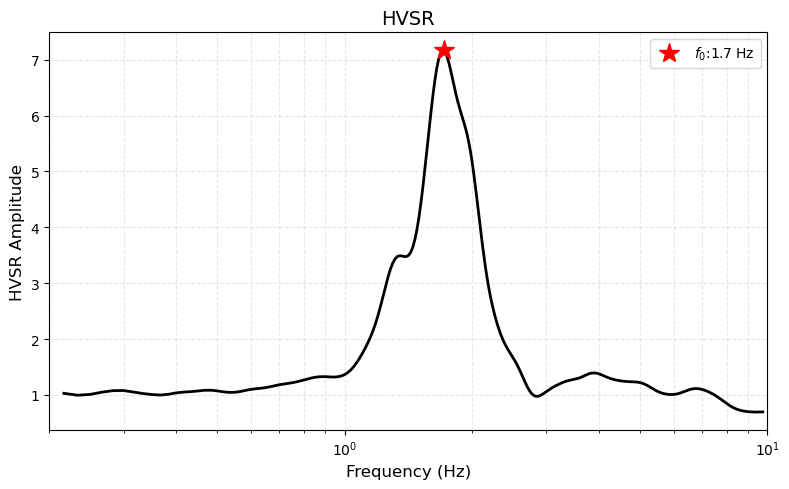

In [7]:
# Additional visualization
freq = result.frequencies
hvsr = result.hvsr_values
# Find peak in frequency range of interest (e.g., 0.2-10 Hz)
freq_mask = (freq >= 0.2) & (freq <= 10.0)
peak_idx = np.argmax(hvsr[freq_mask])
peak_freq = freq[freq_mask][peak_idx]
peak_amp = hvsr[freq_mask][peak_idx]


fig, ax = plt.subplots(1, 1, figsize=(8, 5))

ax.plot(freq, hvsr, 'k-', linewidth=2)
ax.plot(peak_freq, peak_amp, 'r*', markersize=15,label=fr'$f_0$:{peak_freq:.1f} Hz')
ax.set_xlabel('Frequency (Hz)', fontsize=12)
ax.set_ylabel('HVSR Amplitude', fontsize=12)
ax.set_title('HVSR', fontsize=14)
ax.set_xscale('log')
ax.set_xlim(0.2, 10)
ax.grid(alpha=0.3, which='both', linestyle='--')
ax.legend()

plt.tight_layout()
plt.show()